# Intro to the model

In [1]:
!pip install flopy
!pip install pyemu

In [1]:
import os
import shutil
import platform
import pandas as pd
import matplotlib.pyplot as plt
import sys
# sys.path.append(os.path.join("..", "..", "dependencies"))
import flopy
import pyemu

sys.path.insert(0,"..")
import herebedragons as hbd

In [2]:
org_ws = os.path.join('..', '..', 'models', 'monthly_model_files_1lyr_newstress')
sim_ws = os.path.join('freyberg_mf6')
# remove existing folder
if os.path.exists(sim_ws):
    shutil.rmtree(sim_ws)
shutil.copytree(org_ws, sim_ws)
hbd.prep_bins(sim_ws)

In [12]:
# load simulation
sim = flopy.mf6.MFSimulation.load(sim_ws=sim_ws, verbosity_level=0)

# load flow model
gwf = sim.get_model()

# run the model
#sim.run_simulation()
pyemu.os_utils.run("mf6",cwd=sim_ws)

mf6.exe


In [ ]:
sim

In [9]:
dis = gwf.dis
print(f'layers:{dis.nlay.get_data()} nrows:{dis.nrow.get_data()} columns:{dis.ncol.get_data()}')

layers:1 nrows:40 columns:20


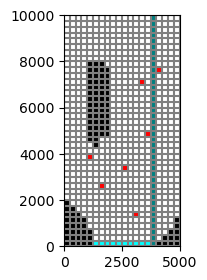

In [12]:
# plot
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mm = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=0)
mm.plot_grid()
mm.plot_inactive()
# Plot grid 
# you can plot BC cells using the plot_bc() 
mm.plot_bc('ghb')
mm.plot_bc('sfr')
mm.plot_bc('wel');

Take a quick look at everyone's favourite parameter, hydraulic conductivity (K):

In [ ]:
for lay in range(gwf.dis.nlay.array):
    print(f'K in layer {lay+1}:', "{:10.1f}".format(gwf.npf.k.get_data(lay).mean()))

In [ ]:
gwf.npf.k.plot(colorbar=True, mflay=0);

Surface topography and the bottom elevation are not uniform (see plots below), with a top and bottom elevation of 32.5m and 30m, respectively.

In [ ]:
# plot model top
gwf.dis.top.plot(colorbar=True, masked_values=[-1049.99])

# plot bottom of bottom layer
gwf.dis.botm.plot(colorbar=True);

### Time Discretisation

The model simulates 25 stress-periods: 1 steady-state, followed by 24 transient stress periods. 

Conceptualy, the first 12 transient stress periods represent the "historical" conditions. Simulated outputs from this period (using the "true" parameter field) are used as "observations" for history matching. These represent field measurments in from our fictional site.

The last 12 transient stress periods conceptualy represent the unmeasured, future condition. The period for which predictions are required. Selected model outputs simulated during this period form a set of "forecasts" or "predicitons" of management interest. 

## Observation Data

The following field data are available as "observations" for the purposes of history matching:
 - surface-water flow at the terminal reach (stress period 2 to 13);
 - groundwater levels at two sites (stress period 2 to 13); 

"Measured" data was generated using the same model, but with higher spatial and temporal resolution (i.e. a finer grid and daily stress periods) and randomly generated parameters.

In [ ]:
obs_data = pd.read_csv(os.path.join('..','..','models','daily_freyberg_mf6_truth','obs_data.csv'))
obs_data = obs_data.pivot(index='time', columns='site', values='value')
obs_data.head()

Model simulated counterparts to these observations are recorded in external CSV files. Let's take a look:

In [ ]:
# check the output csv file names
for i in gwf.obs:
    print(i.output.obs_names)

We can read the `sfr.csv` output file, and inspect the values:

In [ ]:
sfr_obs = pd.read_csv(os.path.join(sim_ws, 'sfr.csv'))
sfr_obs.head()

Simulated values for surface-water flow at the terminal reach are recorded in the "GAGE1" column:

In [ ]:
site = 'GAGE-1'
fig,ax=plt.subplots(1,1)
obs_data.plot(y=site, ax=ax, label='measured')
sfr_obs.plot(x='time', y=site, ax=ax, label='modelled')
ax.set_title(site);

Simulated groundwater levels are recorded in the "heads.csv" file. Several monitoring sites are simulated, however there is measured data for a only a few of these. 

The sites for which "measured data" are available are named:
 - TRGW-0-26-6
 - TRGW-0-3-8

The site naming convention is: "TRGW-layer-row-column".

In [ ]:
hds_obs = pd.read_csv(os.path.join(sim_ws, 'heads.csv'))
hds_obs.head()

Let's make a quick plot of time series of simulated groundwater levels at both measured sites:

In [ ]:
for site in ['TRGW-0-26-6','TRGW-0-3-8']:
    fig,ax=plt.subplots(1,1)
    obs_data.plot(y=site, ax=ax, label='measured')
    hds_obs.plot(x='time', y=site, ax=ax, label='modelled')
    ax.set_title(site);

Whilst we are at it, lets just make a plot of the spatial distribution of simulated heads:

In [ ]:
hdobj = gwf.output.head()
times = hdobj.get_times()
hdobj.plot(mflay=0, colorbar=True, totim=times[-1], masked_values=[1e30]);

## Forecasts

Three model simulated outputs are included as forecast "observations". These represent predictions of management interest for our imaginary case. Simulated forecasts are:
 - aggregated surface-water/grounwdater exchange for reaches 1-20 (recorded under "headwater" in the sfr.csv file) during stress period 22;
 - aggregated surface-water/grounwdater exchange for reaches 21-40 (recorded under "tailwater" in the sfr.csv file) during stress period 22;
 - groundwater level at TRGW_0_9_1 at the end of stress period 22;
 - travel time for a particle released in the north-west of the domain to exit the model domain.

These forecasts were selected to represent model outputs that are informed in varying degrees by the history matching data. Throughout the tutorials we will compare our simulated forecast and uncertainty against "true" values obtained by running the same model with which we generated "measured" observation data. 